#Exploration des différentes Métriques d'évaluation

In [1]:
import torch
import torch.nn as nn
import pandas as pd
from fastai.tabular.all import *

In [2]:
#@title Utils function

def plot_roc(learn):
  preds, y , loss = learn.get_preds(with_loss=True)
  probs = np.exp(preds[:,1])
  fpr, tpr, _ = roc_curve(y, probs, pos_label=1)
  roc_auc = auc(fpr, tpr)
  print(f'ROC area is {roc_auc}')
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Worst case')
  plt.xlim([-0.01, 1.0])
  plt.ylim([0.0, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  return fpr, tpr

In [3]:
path = untar_data(URLs.ADULT_SAMPLE)
path.ls()

(#3) [Path('/root/.fastai/data/adult_sample/export.pkl'),Path('/root/.fastai/data/adult_sample/adult.csv'),Path('/root/.fastai/data/adult_sample/models')]

In [4]:
df = pd.read_csv(path/'adult.csv')
df.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,49,Private,101320,Assoc-acdm,12.0,Married-civ-spouse,NaN,Wife,White,Female,0,1902,40,United-States,>=50k
1,44,Private,236746,Masters,14.0,Divorced,Exec-managerial,Not-in-family,White,Male,10520,0,45,United-States,>=50k
2,38,Private,96185,HS-grad,NaN,Divorced,NaN,Unmarried,Black,Female,0,0,32,United-States,<50k
3,38,Self-emp-inc,112847,Prof-school,15.0,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>=50k
4,42,Self-emp-not-inc,82297,7th-8th,NaN,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,50,United-States,<50k


In [5]:
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race']
cont_names = ['age', 'fnlwgt', 'education-num']

In [53]:
df.shape

(32561, 15)

In [50]:
"""Méthode 1)"""
from fastai.tabular.model import TabularModel

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
                                  cat_names=cat_names, cont_names=cont_names,
                                  procs = [Categorify, FillMissing, Normalize])

tab_learn = tabular_learner(dls,metrics=accuracy)
tab_learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(17, 8)
    (2): Embedding(8, 5)
    (3): Embedding(16, 8)
    (4): Embedding(7, 5)
    (5): Embedding(6, 4)
    (6): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=42, out_features=200, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=200, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=100, out_features=2, bias=True)
    )
  )
)

In [52]:
tab_learn.fit(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.621601,0.670800,0.790233,00:00
1,0.618884,0.670516,0.788083,00:00


La métrique indiquée dans 'metrics=' correspond à notre méthode d'évaluation des performances de notre modèle. En ce sens, elle doit être la plus représentative possible de ces performances et être sensible à d'éventuels disfonctionnement de notre algorithme. Ici, la métrique que nous avons définie est l' "accuracy", donc la fraction des données de validation qui a été classifié correctement.

Cette métrique dépend néanmoins de la structure de la base de données. Par exemple, si celle-ci n'est pas équilibrée et n'arrive jamais à classifier des données d'une même classe peu présentes dans la base de données de validation correctement, la précision de classification sera importante, alors que ce cas de figure peut être critique lors de la classification d'image médicale pour l'aide au diagnostic par exemple.

De ce fait, nous pouvons définir plusieurs métriques qui englobent ce genre de phénomène. Par exemple, nous avons vu la matrice de confusion lors des séances précédentes. 

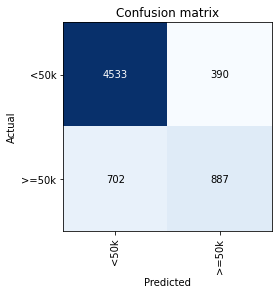

In [ ]:
ci = ClassificationInterpretation.from_learner(tab_learn)
ci.plot_confusion_matrix()

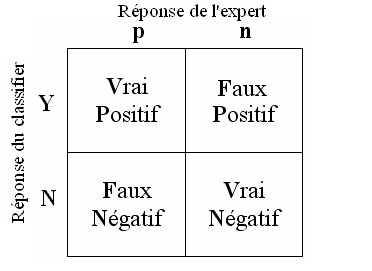

De cette matrice de confusion, pour une classification binaire, nous en retirons les VP, FP, FN et VN. 

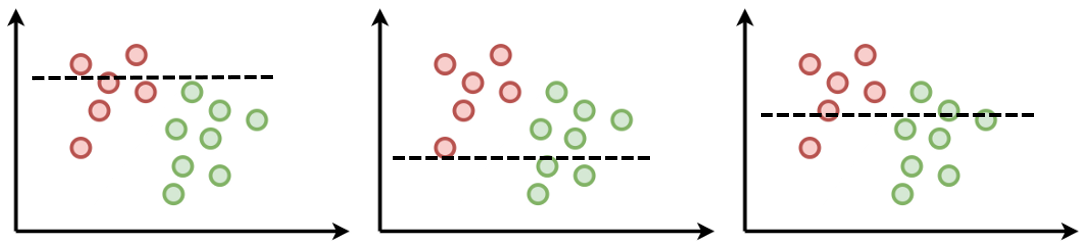

Par exemple, de ces informations, 

$accuracy = \frac{TP+TN}{P+N}$


Deux autres métriques populaires sont définis comme suit :

1.   $FPR = \frac{FP}{N} = \frac{FP}{TN+FP}$
2.   $TPR = \frac{TP}{P} = \frac{TP}{TP+FN}$ que l'on appelle la sensibilité (sensitivity en anglais)
3. $TNR = = \frac{TN}{N} = \frac{TN}{TN+FP} = 1 - FPR$ que l'on appelle la spécificité (spcecificity en anglais)
4. $FNR = = \frac{FN}{N} = \frac{FN}{TN+FP} = 1 - TPR$ 

Ainsi, la courbe $ROC$ est une courbe qui regroupe l'influence du $FPR$ et $TPR$.


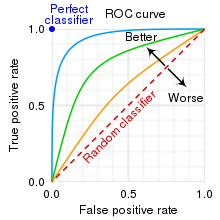

De fait, l'aire sous la courbe de ce graphe augmente avec les performances du réseau. La métrique $ROC-AUC$ (ROC Area-Under-the-Curve) est donc également pertinent dans la tâche d'évaluation de réseau de classification. 

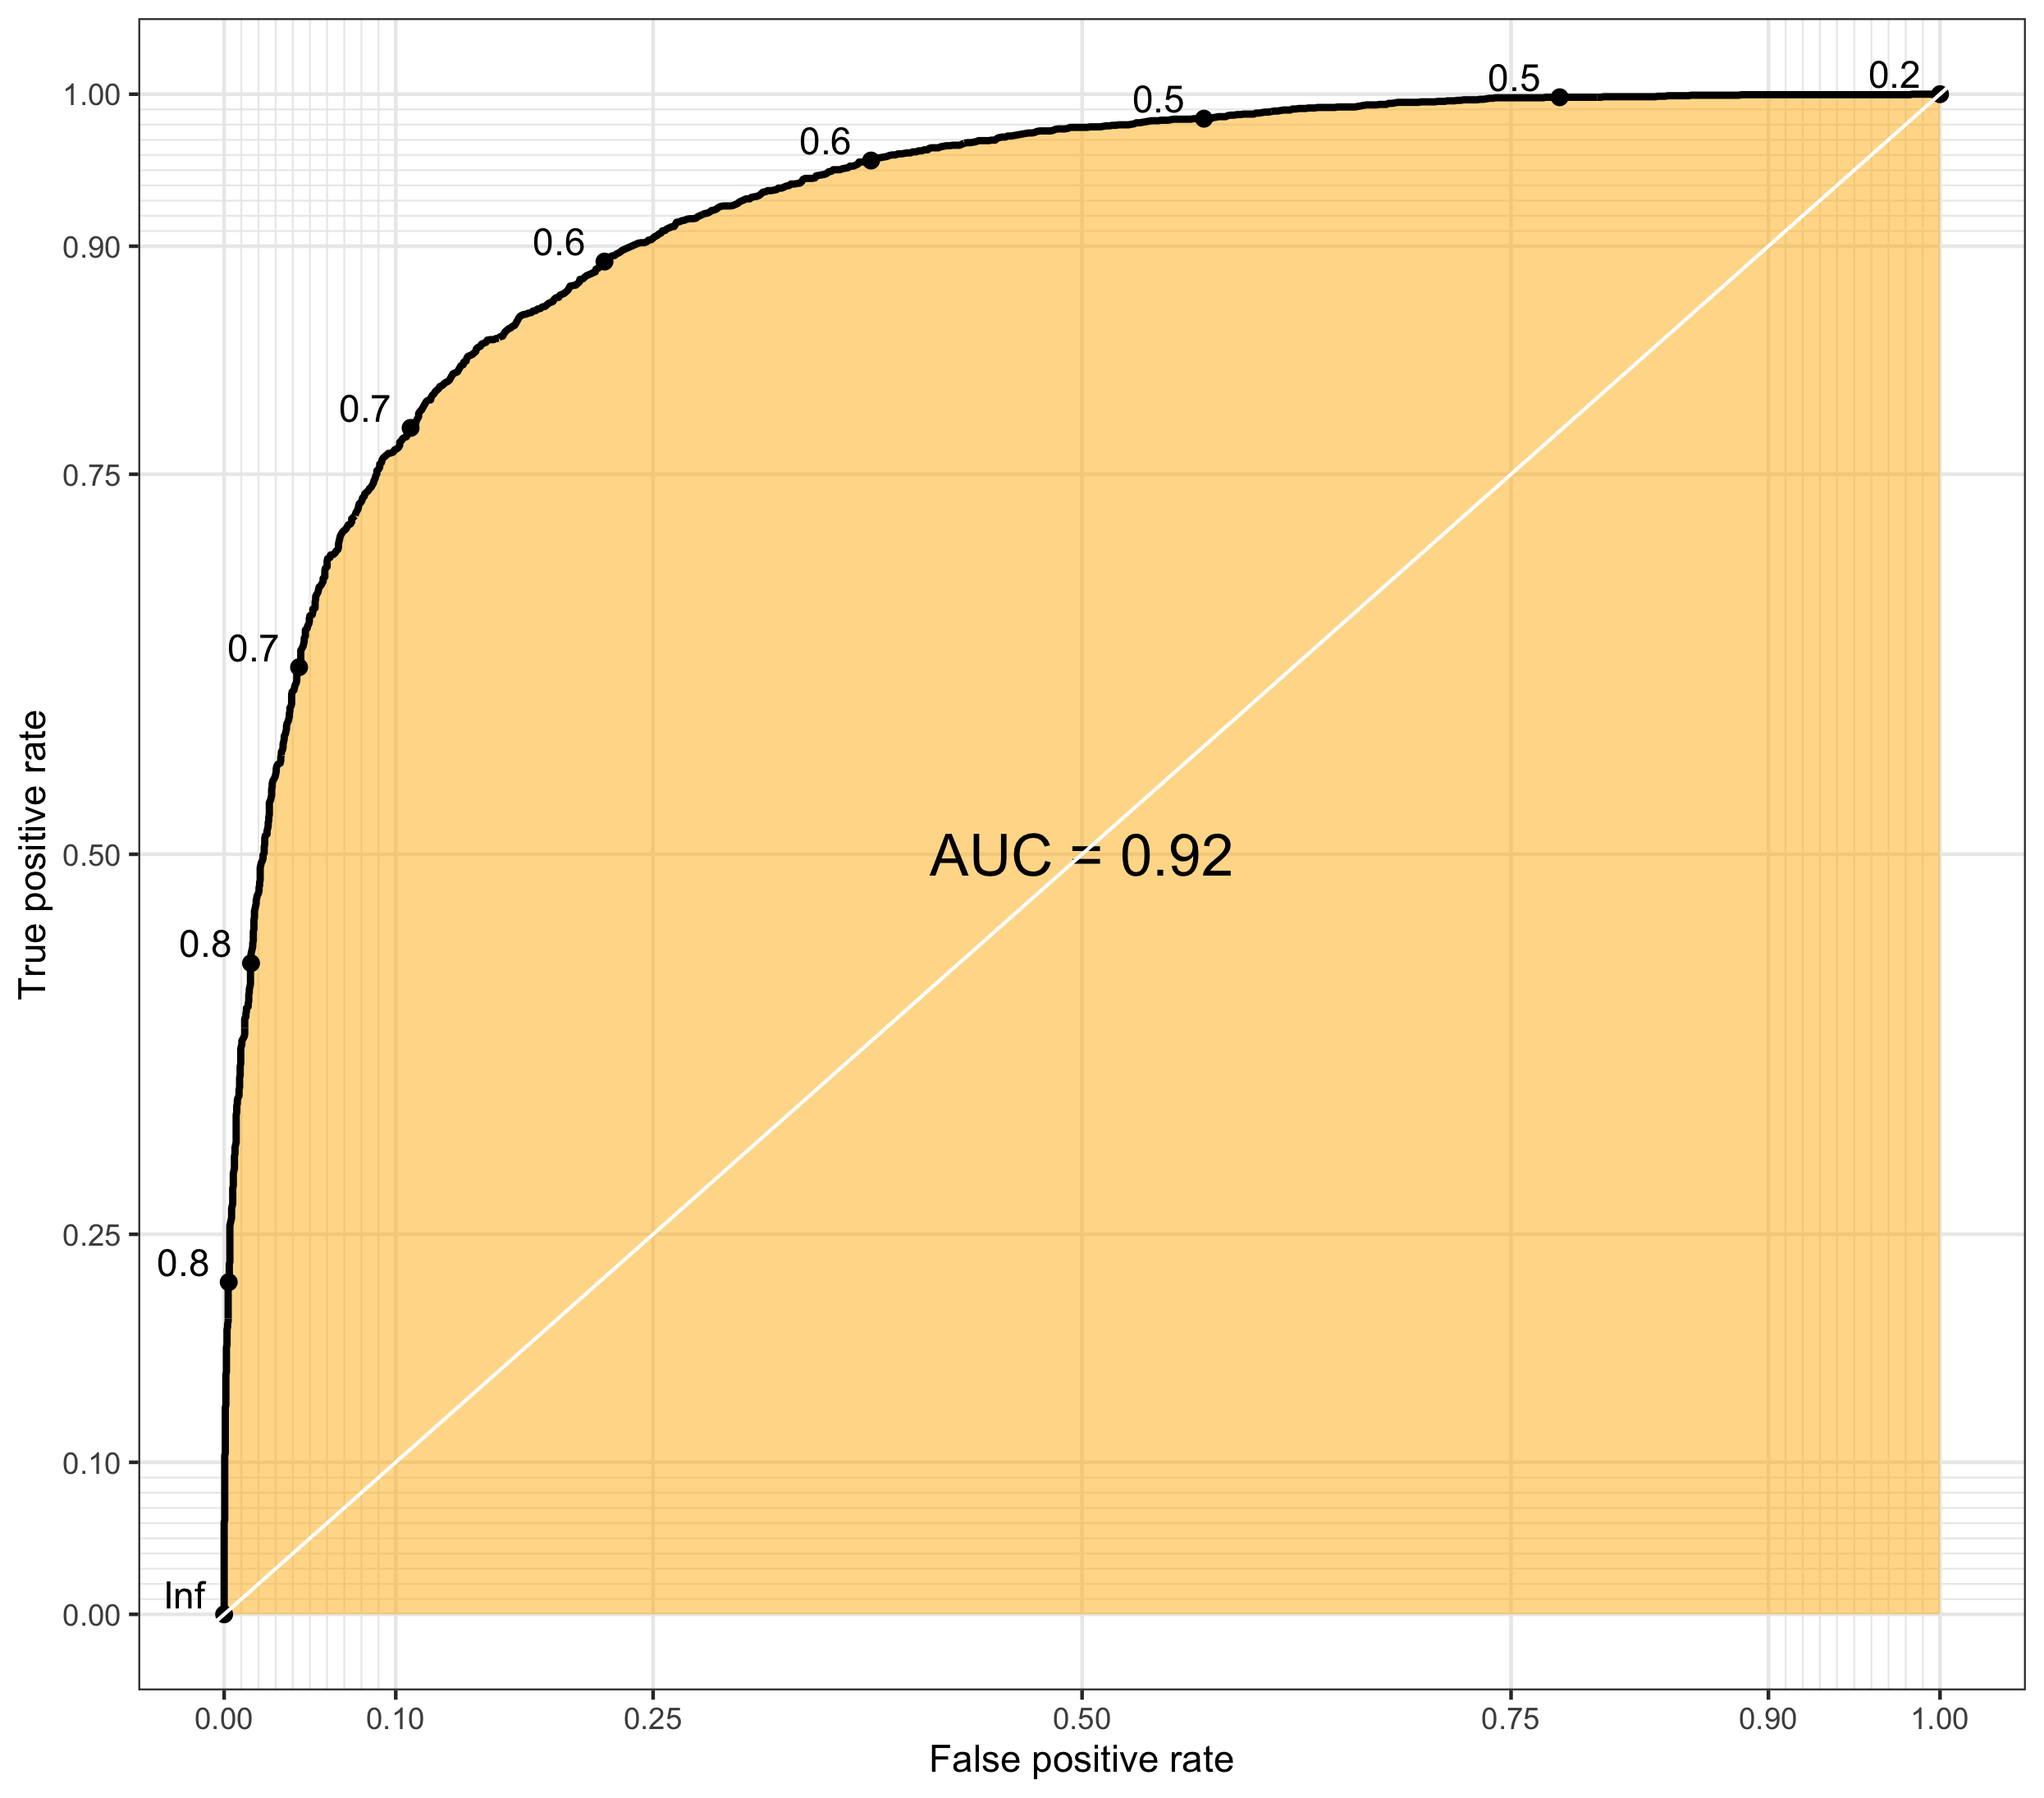

### Exercice 1) 
Afficher la ROC-AUC calculé lors de l'entrainement.


In [ ]:
torch.cuda.empty_cache()
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
                                  cat_names=cat_names, cont_names=cont_names,
                                  procs = [Categorify, FillMissing, Normalize])
roc_auc = ___()
tab_learn = tabular_learner(dls,___=___)
tab_learn.fit(10)

epoch,train_loss,valid_loss,roc_auc_score,time
0,0.369438,0.346842,0.889219,00:03
1,0.373659,0.345485,0.888888,00:04
2,0.360930,0.342933,0.889956,00:07
3,0.354016,0.345751,0.888513,00:05
4,0.355159,0.345853,0.889930,00:03
5,0.352519,0.343954,0.890616,00:03
6,0.362741,0.345852,0.888225,00:03
7,0.350286,0.341537,0.892606,00:03
8,0.358990,0.341237,0.891866,00:03
9,0.345088,0.338667,0.893252,00:03


learn.get_preds() permet de récupérer les prédictions du modèles sur la base de données de validation

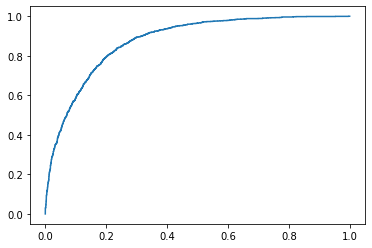

In [8]:
from sklearn.metrics import roc_curve, auc

preds, y , loss = tab_learn.get_preds(with_loss=True)
probs = np.exp(preds[:,1])
fpr, tpr, _ = roc_curve(y, probs, pos_label=1)
plt.plot(fpr, tpr)
plt.show()

#Proper display of roc curve (uncomment line below)
#plot_roc(tab_learn)

Une autre métrique populaire est le $F_1$ score et se définit comme la moyenne harmonique entre la $Precision$ et le $Recall$

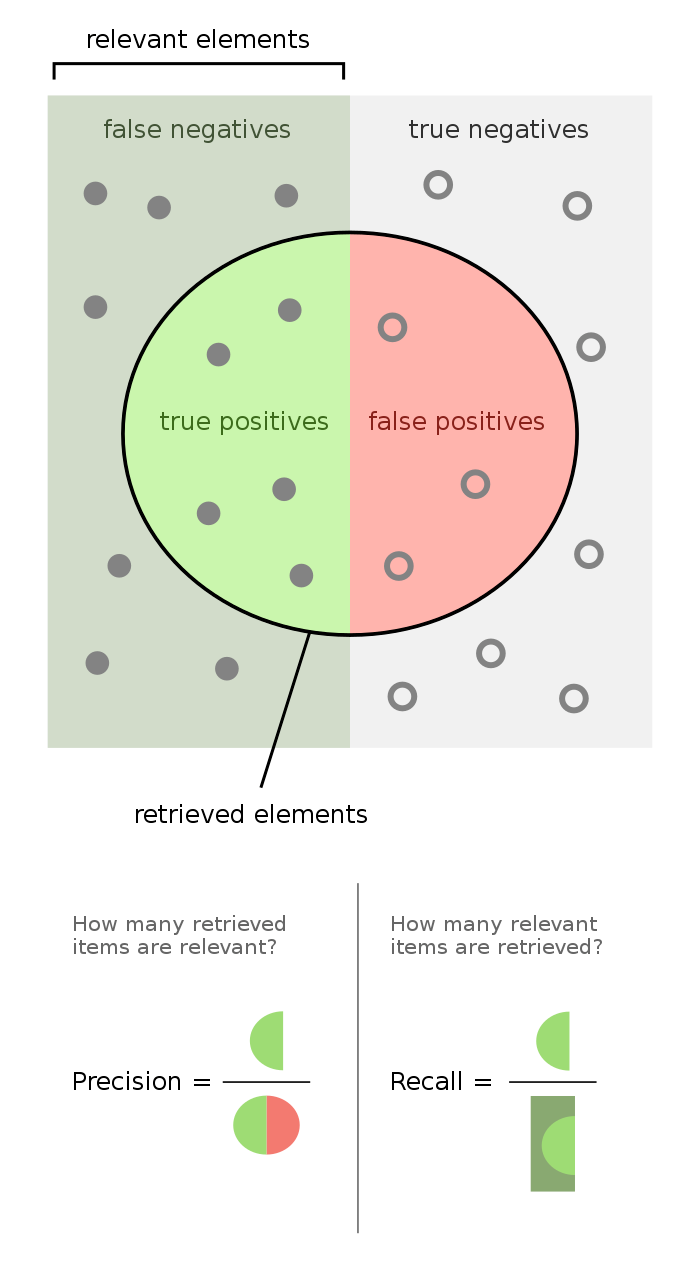

In [ ]:
torch.cuda.empty_cache()
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
                                  cat_names=cat_names, cont_names=cont_names,
                                  procs = [Categorify, FillMissing, Normalize])
f1 = F1Score()

tab_learn = tabular_learner(dls,metrics=f1)
tab_learn.fit(10)

#Exploration des différentes Métriques d'entrainement

Durant l'entrainement d'un réseau de neurones, la prédicition du réseau est comparée au label donné par une fonction qu'on appelle en anglais $loss$. Cette loss function est fondamentale car c'est sur le résultat de cette fonction que va se calculer les gradients, valeures essentielles à l'update des poids durant chaque itération d'entrainement

In [ ]:
tab_learn.loss_func #Loss fonction du learner que l'on a définit

FlattenedLoss of CrossEntropyLoss()

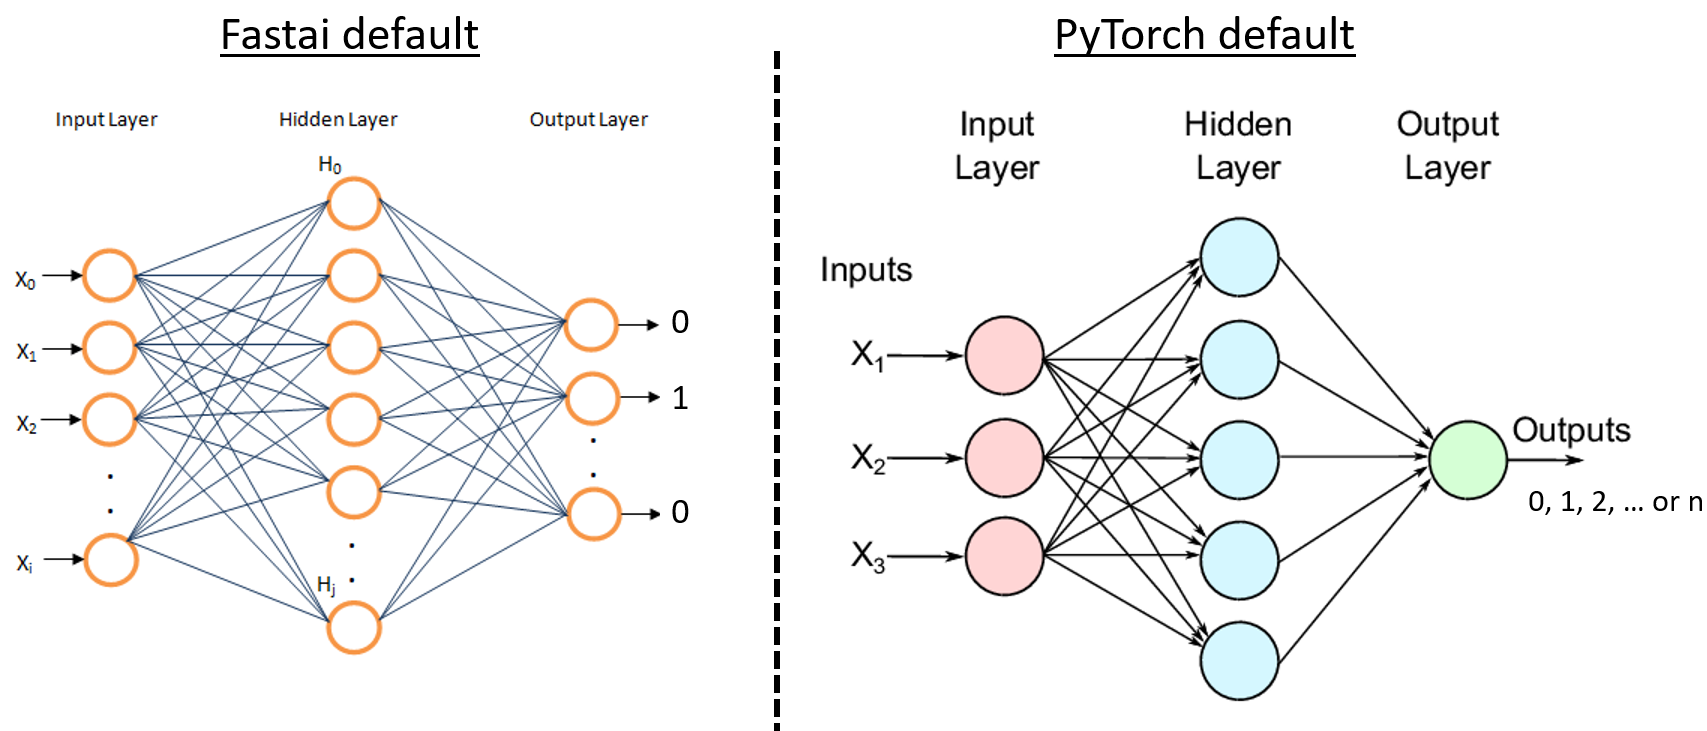

## Losses pour Regression

La Mean Squarred Error (MSE) permet de prendre en compte la différence (au carré) entre la sortie prédite et la sortie voulue ⇒ On tend vers des valeurs proches des valeurs target

L'explained variance est une metrique qui permet de calculer à quel point notre modèle est capable de répliquer les variations au sein des données

Ici, on essaie de deviner le nombre d'heures de travail par semaine

In [19]:
torch.cuda.empty_cache()

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="hours-per-week",
                                  cat_names=cat_names, cont_names=cont_names,
                                  procs = [Categorify, FillMissing, Normalize])
xvar = ExplainedVariance()
mse_loss = MSELossFlat()

tab_learn = tabular_learner(dls,metrics=xvar, loss_func=mse_loss)
tab_learn.fit(3)

epoch,train_loss,valid_loss,explained_variance_score,time
0,583.936768,404.005371,0.243775,00:03
1,118.124435,115.689285,0.240344,00:03
2,118.970299,114.220505,0.249937,00:03


La Mean Absolute Error prend en compte la valeur absolue de la différence entre prediction et target

Ici, on utilise la Rooot Mean Square Error en tant que métrique

In [25]:
torch.cuda.empty_cache()

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="hours-per-week",
                                  cat_names=cat_names, cont_names=cont_names,
                                  procs = [Categorify, FillMissing, Normalize])
mae = L1LossFlat()

tab_learn = tabular_learner(dls,metrics=mse, loss_func=mae)
tab_learn.fit(3)

epoch,train_loss,valid_loss,_rmse,time
0,17.858641,12.623185,16.254072,00:04
1,7.130767,7.172542,11.322751,00:03
2,6.973676,6.914985,11.102351,00:03


## Exercice 2

Entraîner tab_learn en minimisant la racine carrée de la moyenne des carrés des erreur et en mesurant la corrélation entre les prédictions et les target

Tips : racine carrée = root

## Losses pour classification

Utilisation de la CrossEntropyLoss

In [ ]:
torch.cuda.empty_cache()

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
                                  cat_names=cat_names, cont_names=cont_names,
                                  procs = [Categorify, FillMissing, Normalize])
f1 = F1Score()
ce = CrossEntropyLossFlat()

tab_learn = tabular_learner(dls,metrics=f1, loss_func=ce)
tab_learn.fit(10)

Utilisation de la Focal Loss

In [34]:
torch.cuda.empty_cache()
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
                                  cat_names=cat_names, cont_names=cont_names,
                                  procs = [Categorify, FillMissing, Normalize])
f1 = F1Score()
focal_loss = FocalLossFlat()

tab_learn = tabular_learner(dls,metrics=f1, loss_func=focal_loss)
tab_learn.fit(3)

epoch,train_loss,valid_loss,f1_score,time
0,0.097520,0.096225,0.597068,00:04
1,0.095589,0.092738,0.614275,00:04
2,0.095334,0.093021,0.613314,00:05


#Les Callback Fastai

Des Callbacks sont des classes qui sont appelés lors d'évènement particulier lors de l'entrainement du réseau de neurones. Ils permettent de facilement interagir avec le modèle et les paramètres de l'entrainement durant celui-ci.

Les callbacks se concatènent sous forme de liste qui est ensuite passée dans le learner de fastAI à partir du keyword 'cbs'

In [41]:
torch.cuda.empty_cache()
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
                                  cat_names=cat_names, cont_names=cont_names,
                                  procs = [Categorify, FillMissing, Normalize])
f1 = F1Score()
focal_loss = FocalLossFlat()

cbs = [CSVLogger('/content/saved_results.csv')]

tab_learn = tabular_learner(dls,metrics=f1, loss_func=focal_loss, cbs=cbs)
tab_learn.fit(3)

epoch,train_loss,valid_loss,f1_score,time
0,0.099208,0.096297,0.611904,00:04
1,0.096562,0.092139,0.648271,00:04
2,0.097216,0.092645,0.603233,00:04


In [42]:
my_results = pd.read_csv('saved_results.csv')
my_results.head

## Exercice 3

Utiliser un Callback qui permet de sauvegarder le modèle les paramètres qui minimisent la training loss. À quelle epoch ces paramètres correspondent ? Tout en gardant le CSVLogger.

Tips: "tracking callback", "sauvegarder le model"


In [ ]:
### Votre code ###

## Optimisation de l'entraînement

Pour éviter l'overfitting, il faut connaître le nombre d'epoch optimal (pas trop, ni trop peu). On peut utiliser un Callback pour s'arrêter au bon moment.

## Exercice 4

Implementer ce callback avec une patience de 2 en entraînant sur 20 epochs

In [ ]:
### Votre code ###

## Optimisation de la mémoire
Si on veut simuler un très grand batch_size sans surcharger la RAM, on peut utiliser le "GradientAccumulation" callback. 

## Exercice 5
Entraîner un modèle en passant 4 images à la fois mais en mettant les paramètres à jour que toutes les 5 epochs

Tips : n_acc correspond au nombre d'entrées vues

In [ ]:
### Votre code ###

Séquence des différentes opérations durant l'entraînement

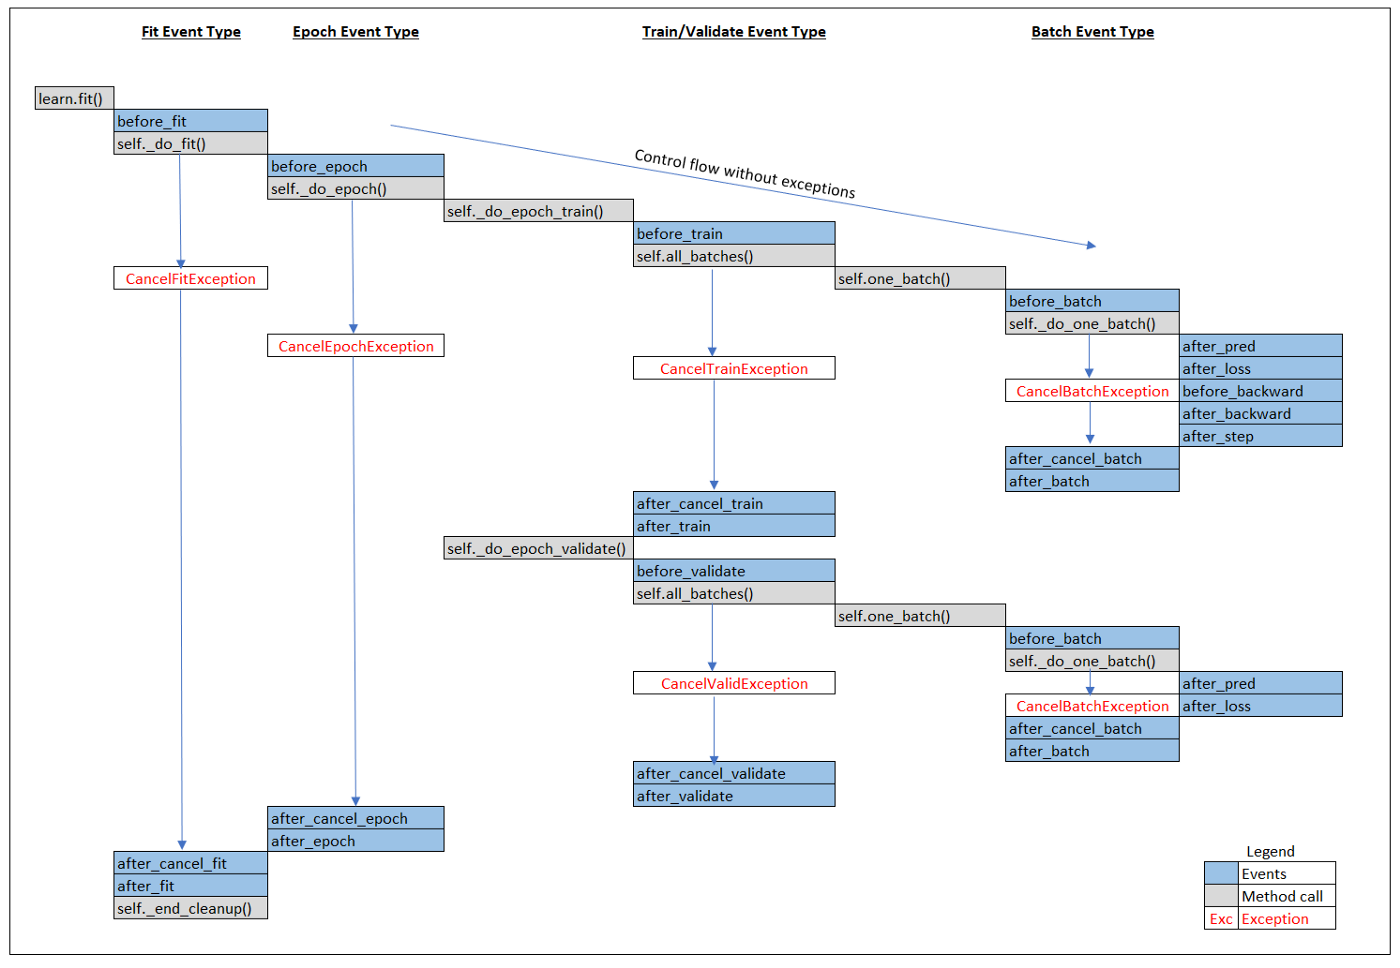

## Exercice 6

Estimer l'âge en ajoutant le salaire dans les infos d'entrée (et en retirant l'âge des entrées LOL). Quelles sont les losses/métriques les plus pertinantes dans ce cas ? Entraîner le modèle sur un nombre optimal d'epoch avec un batch size équivalent à 2048 (mais bs=64), sauvegarder les meilleurs paramètres dans un fichier 'ex6_best.pth'.

In [ ]:
### Votre code

## Exercice 7

Estimer le sexe en ajoutant le salaire dans les infos d'entrée. Quelles sont les losses/métriques les plus pertinantes dans ce cas ? Entraîner le modèle sur un nombre optimal d'epoch avec un batch size équivalent à 2048 (mais bs=64), sauvegarder les meilleurs paramètres dans un fichier 'ex7_best.pth'.

In [ ]:
### Votre code

Pour info, exemple d'un Callback custom

In [ ]:
class MyCustomCallback(Callback):
  def __init__(self, add_to_loss):
    self.add_to_loss = add_to_loss
  def before_batch(self):
    self.learn.yb = (self.yb[0].float(),) # changer le type des données de targer

  def after_loss(self):
    if self.y[0][0] == 0:
      self.learn.loss = self.loss + self.add_to_loss
    elif self.y[0][0] == 1:
      self.learn.loss = self.loss - self.add_to_loss

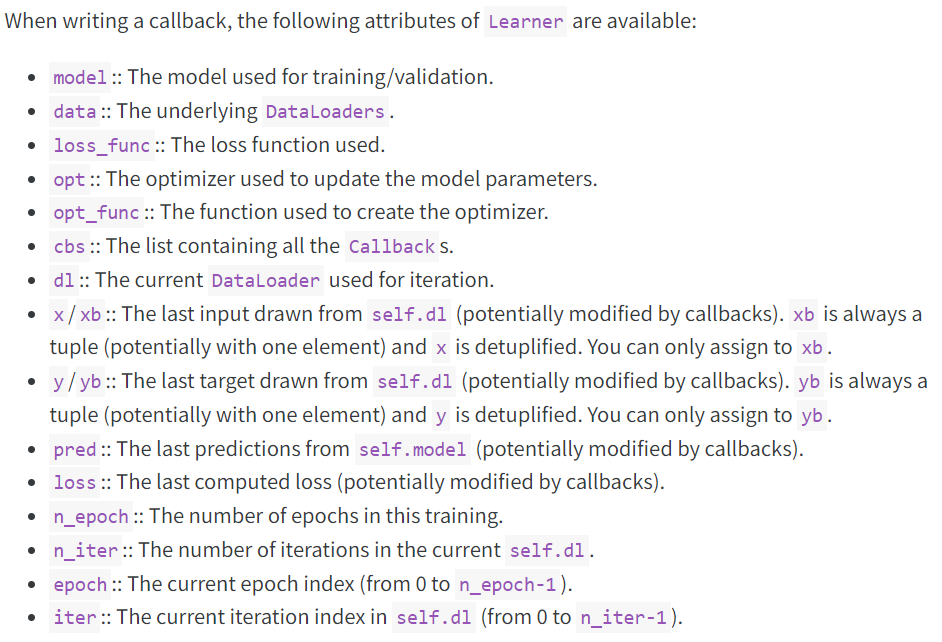